In [1]:
!pip install git+https://github.com/jsh9/python-plot-utilities

  Cloning https://github.com/jsh9/python-plot-utilities to c:\users\ttalp\appdata\local\temp\pip-req-build-envzjfq_
  Created wheel for plot-utils: filename=plot_utils-0.6.6-py3-none-any.whl size=13278151 sha256=323f65b5b4f812d403f13a1c78ad1aebf5cf7f977b9c533e8fa07903c7767099
  Stored in directory: C:\Users\ttalp\AppData\Local\Temp\pip-ephem-wheel-cache-5827khn5\wheels\6d\3f\b7\ac663da9fc0566bd2bfdbbcf98dee2f8f601abaf483b6106b9
Successfully built plot-utils


In [2]:
from brian2 import *
import sympy
import plot_utils

INFO       Cache size for target "cython": 2117 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\SPB_Data\.cython\brian_extensions" directory. [brian2]


In [3]:
def neuron_define(input_neurons):
    input_layer=[*range(0,input_neurons)]
    inhib_layer=[*range(input_neurons,2*input_neurons)]
    left_layer=[*range(2*input_neurons,3*input_neurons-1)]
    right_layer=[*range(3*input_neurons-1,4*input_neurons-2)]
    left_neuron=[4*input_neurons-2]
    right_neuron=[4*input_neurons-1]
    no_excitatory_neurons= len(input_layer+left_layer+right_layer+left_neuron+right_neuron)
    no_inhibitory_neurons= len(inhib_layer)
    return input_layer, inhib_layer, left_layer, right_layer, left_neuron, right_neuron, no_excitatory_neurons, no_inhibitory_neurons

def synapse_generator(input_neurons):
    i = [] #pre synaptic
    j = [] #post synaptic
    a = neuron_define(input_neurons)
    for index in a[0]:
        #connect the layer between input layer and the inhib layer, a[1] is inhib layer.
        i.append(a[0][index])
        j.append(a[1][index])
        if index != a[0][0]:
            #connect the layer between input layer and the left layer, a[2] is left layer.
            i.append(a[0][index])
            j.append(a[2][index-1])
            #connect the layer between inhib layer and the right layer.
            i.append(a[1][index])
            j.append(a[3][index-1])
        #connect the layer between input layer and the right layer, a[3] is right layer.
        if index != a[0][-1]:
            i.append(a[0][index])
            j.append(a[3][index])
            #connect the layer between inhib layer and the left layer.
            i.append(a[1][index])
            j.append(a[2][index])
            #connect the left layer to the left neuron
            i.append(a[2][index])
            j.append(a[4][0])
            #connect the right layer to the right neuron
            i.append(a[3][index])
            j.append(a[5][0])
        
    return i,j,a[6],a[7]

def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1) 
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [4]:
print(neuron_define(6))



i,j,N_e,N_i = synapse_generator(6)
print('i = ', i)
print('\n j = ', j)
print('\n N_e = ', N_e)
print('\n N_i = ', N_i)





([0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16], [17, 18, 19, 20, 21], [22], [23], 18, 6)
i =  [0, 0, 6, 12, 17, 1, 1, 7, 1, 7, 13, 18, 2, 2, 8, 2, 8, 14, 19, 3, 3, 9, 3, 9, 15, 20, 4, 4, 10, 4, 10, 16, 21, 5, 5, 11]

 j =  [6, 17, 12, 22, 23, 7, 12, 17, 18, 13, 22, 23, 8, 13, 18, 19, 14, 22, 23, 9, 14, 19, 20, 15, 22, 23, 10, 15, 20, 21, 16, 22, 23, 11, 16, 21]

 N_e =  18

 N_i =  6


Halfway there
Starting simulation at t=0. s for a duration of 20. ms
20. ms (100%) simulated in < 1s


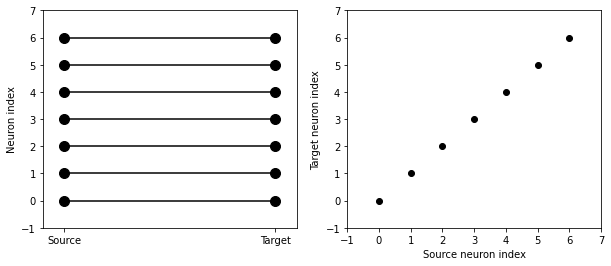

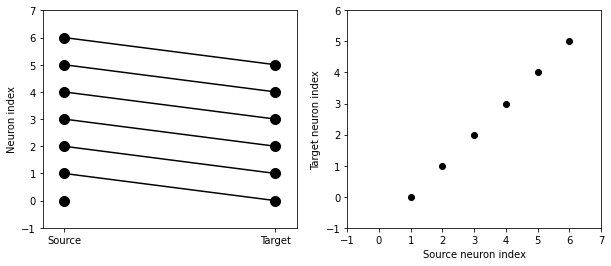

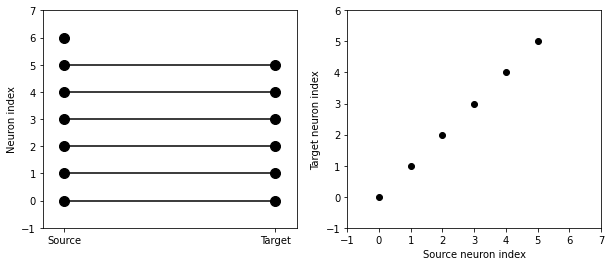

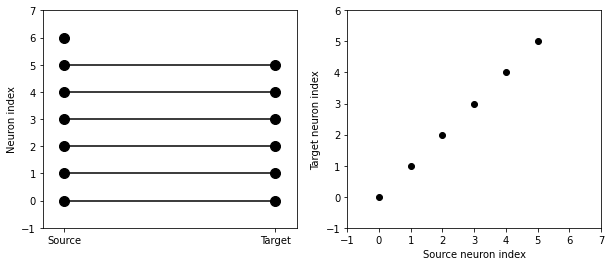

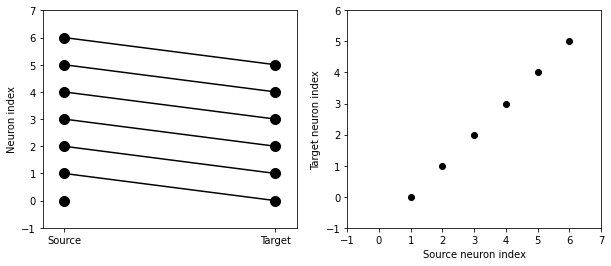

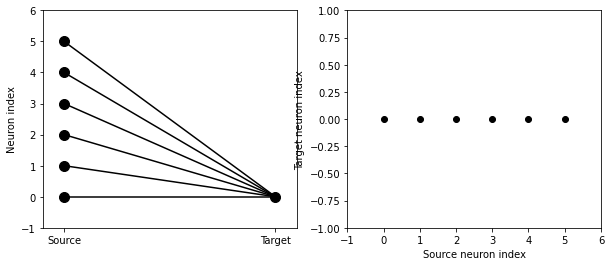

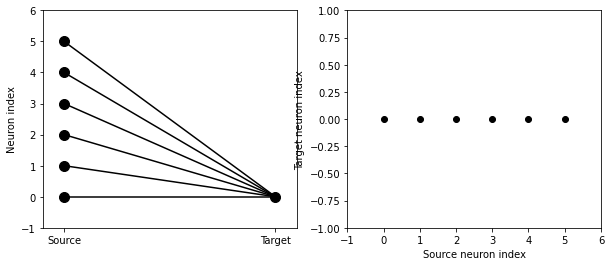

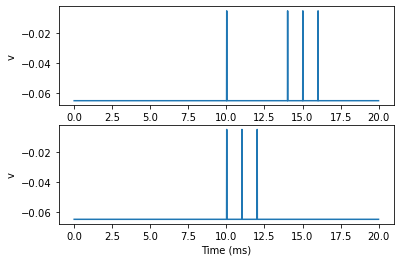

In [33]:
#https://brian2.readthedocs.io/en/stable/examples/frompapers.Stimberg_et_al_2018.example_1_COBA.html
start_scope()

seed(11922)  # to get identical figures for repeated runs

################################################################################
# Model parameters
################################################################################
### General parameters


input_neurons = 7 ### insert no of input neurons here ###
i,j,N_e,N_i = synapse_generator(input_neurons) # Calls the function with connections

duration = 20*ms      # Total simulation time
sim_dt = 0.01*ms        # Integrator/sampling step


### Neuron parameters
tau_m = 30*ms         # Excitatory synaptic time constant
V_th = -50e-3         # Firing threshold
V_r = -65e-3          # Reset potential       
R = 90e6




### Synapse parameters
we = 1          # Excitatory synaptic weight
wi = -1           # Inhibitory synaptic weight

indices = [3,4,5,6,5,4,3] #np.linspace(0, 50, num=2)
times = [10,11,12,13,14,15,16]*ms #np.linspace(10, 90, num=2)*ms




################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### Neurons
neuron_eqs = '''
dv/dt = ((V_r-v)+R*I)/tau_m : 1
I : 1
'''
input_group = NeuronGroup(input_neurons, model=neuron_eqs,threshold='v>V_th', reset='v=V_r', method='euler')

neurons = NeuronGroup(3*input_neurons-2, model=neuron_eqs,threshold='v>V_th', reset='v=V_r', method='euler')

left = NeuronGroup(1, model=neuron_eqs,threshold='v>V_th',reset='v=V_r', method='euler')

right = NeuronGroup(1, model=neuron_eqs,threshold='v>V_th',reset='v=V_r', method='euler')

neurons.I  = 50e-12
neurons.v = input_group.v = left.v = right.v = 'V_r'

input_layer = SpikeGeneratorGroup(input_neurons, indices, times, dt=sim_dt) # assigs 1/4 of the neurons to the input layer
#input_layer = input_group[:input_neurons]
inh_neurons = neurons[:input_neurons] # assigs 1/4 of the neurons to the inhibitory layer
left_layer  = neurons[1*input_neurons:2*input_neurons-1] # assigs 1/4 -1 of the neurons to the left exitatory layer
right_layer = neurons[2*input_neurons-1:3*input_neurons-2] # assigs 1/4 -1 of the neurons to the right exitatory layer
left_neuron = left[0] # assigns 1 of the neurons to the final left layer
right_neuron= right[0] # assigns 1 of the neurons to the final right layer

### Synapses
exc_syn = Synapses(input_layer, inh_neurons, model = 'w : 1', on_pre = 'v += w') # Connects the input layer to the inhibitory layer
exc_syn_left = Synapses(input_layer, left_layer, model = 'w : 1', on_pre = 'v += w') # Connects the input layer to the left exitatory layer
exc_syn_right = Synapses(input_layer, right_layer, model = 'w :1', on_pre = 'v += w') # Connects the input layer to the right exitatory layer
inh_syn_right = Synapses(inh_neurons, right_layer, model = 'w : 1', on_pre = 'v += w') # Connects the inhibitory layer to the right exitatory layer
inh_syn_left = Synapses(inh_neurons, left_layer, model = 'w : 1', on_pre = 'v += w') # Connects the inhibitory layer to the left exitatory layer
final_left = Synapses(left_layer, left_neuron, model = 'w : 1', on_pre = 'v += w') # Connects the left exitatory layer to the final left neuron
final_right = Synapses(right_layer, right_neuron, model = 'w : 1', on_pre = 'v += w') # Connects the right exitatory layer to the final right neuron

exc_syn.connect(i=[*range(0,input_neurons)],j=[*range(0,input_neurons)])
exc_syn_left.connect(i=[*range(1,input_neurons)],j=[*range(0,input_neurons-1)])
exc_syn_right.connect(i=[*range(0,input_neurons-1)],j=[*range(0,input_neurons-1)])
inh_syn_right.connect(i=[*range(1,input_neurons)],j=[*range(0,input_neurons-1)])
inh_syn_left.connect(i=[*range(0,input_neurons-1)],j=[*range(0,input_neurons-1)])
final_left.connect(i=[*range(0,input_neurons-1)],j=0)
final_right.connect(i=[*range(0,input_neurons-1)],j=0)

exc_syn.w = 60e-3
exc_syn_left.w = 60e-3
exc_syn_right.w = 60e-3
inh_syn_right.w = -100e-3
inh_syn_left.w = -100e-3
final_left.w = 60e-3
final_right.w = 60e-3


visualise_connectivity(exc_syn)
visualise_connectivity(exc_syn_left)
visualise_connectivity(exc_syn_right)
visualise_connectivity(inh_syn_left)
visualise_connectivity(inh_syn_right)
visualise_connectivity(final_left)
visualise_connectivity(final_right)


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
exc_mon = SpikeMonitor(input_layer)
inh_mon = SpikeMonitor(inh_neurons)

### We record some additional data from a single excitatory neuron

M_left = StateMonitor(left_neuron, 'v', record=0)
M_right = StateMonitor(right_neuron, 'v', record=0)
L_right = StateMonitor(inh_neurons, 'v', record=0)

print('Halfway there')




run(duration, report='text')
figure()
subplot(211)
plot(M_left.t/ms, M_left.v[0])
xlabel('Time (ms)')
ylabel('v');
subplot(212)
plot(M_right.t/ms, M_right.v[0])
xlabel('Time (ms)')
ylabel('v');


In [27]:
print(neurons)

NeuronGroup(clock=Clock(dt=10. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_3')


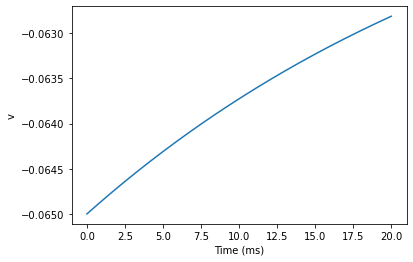

In [34]:


plot(L_right.t/ms, L_right.v[0])
xlabel('Time (ms)')
ylabel('v');
